# Munich R Courses - Deep learning showcase

Content:
1. working with image data in R (downloading data, plotting, preprocessing)
2. creating deep learning architectures using the keras interface
    1. Starting with Fashion MNIST
    3. Evaluation of model output
    4. Storage and loading of models
    2. Sequential and Functional API
3. running and comparing different architectures (FCN, CNN)
5. Regularization and its effects on the generalization performance
6. From bw to rgb images
7. Transfer learning with pretrained models in case of few labeled data


## 1. Working with image data in R

### Data provided by the keras package - MNIST

MNIST is a [famous dataset provided by Yann LeCun et al.](http://yann.lecun.com/exdb/mnist/) that consists of 70K 28x28 grayscale images of handwritten digits.

In [2]:
# install and load the package
# install.packages('keras')
library('keras')

Warning message:
“package ‘keras’ was built under R version 3.4.4”

In [ ]:
# files will be stored at
# ~/.keras/datasets
mnist = dataset_mnist()
# what does the object contain?
str(mnist)
# 60K train and 10K test data with input X and labels y

In [ ]:
# assign values 
x_train = mnist$train$x
x_test = mnist$test$x
y_train = mnist$train$y
y_test = mnist$test$y

In [ ]:
# classes for train and test are equally balanced 
# (-> what if they were not?)
table(y_test)
table(y_train)

In [ ]:
# x_train is an array that contains 60K images with channel size 1 and dimensions 28x28 (as they are black-white)
# resulting in tensor of shape [amount images, xdim, ydim]
# If the images were coloured, they would contain  3 channels (RGB) resulting in shape
# [60000, 28, 28, 3]

# inspect one train image
idx = 87
foo_img = x_train[idx, , ]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))

In [ ]:
# helper to rotate the image
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(foo_img), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Image ', idx, ' with label ', foo_label))

### Data provided by the keras package - Fashion MNIST

Fashion Mnist is mainly a more complicated version of MNIST with 10 classes of different fashion objects. The dataset is published by [Zalando Research](https://github.com/zalandoresearch/fashion-mnist) and also often used for deep learning benchmarks. The dataset as well consists of 70K 28x28 grayscale images of fashion objects in 10 balanced categories such as bags, shoes, trousers, ...

In [ ]:
# files will be stored at
# ~/.keras/datasets
fmnist = dataset_fashion_mnist()
# what does the object contain?
str(fmnist)
# 60K train and 10K test data with input X and labels y
# assign values 
x_train = mnist$train$x
x_test = mnist$test$x
y_train = mnist$train$y
y_test = mnist$test$y

In [ ]:
# inspect one train image
idx = 87
foo_img = x_train[idx, , ]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))
# helper to rotate the image
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(foo_img), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Image ', idx, ' with label ', foo_label))

### Data provided by the keras package - CIFAR 10

Cifar10 is a [public dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html) that contains 60K 32x32 RGB images from 10 classes (airplanes, deer, cars, cats, ...) and is widely used for benchmarking DL algorithms in image classification. 

In [ ]:
# can take up to 5 min as the dataset contains roughly 170MB
# also stored at ~/.keras/datasets
cifar = dataset_cifar10()

In [ ]:
# similar structure as MNIST
# but now with channel depth 3
str(cifar)
x_train = cifar$train$x
y_train = cifar$train$y
x_test = cifar$test$x
y_test = cifar$test$y

In [ ]:
# inspect one train image
# consists of 3 matrices of RGB integers in {0, ..., 255}
idx = 177
foo_img = x_train[idx, , ,]
foo_label = y_train[idx]
cat(paste0('class: ', class(foo_img), 
    '\nmax value: ', max(foo_img), 
    '\nmin value: ', min(foo_img), 
    '\nmean value: ', mean(foo_img),
    '\ndata type: ', typeof(foo_img)))

# print the label 
cat(paste0('\nlabel of image ', idx, ' is ', foo_label))

# plot the images with grid package
# therefore, pixels have to be squashed to [0, 1]
library(grid)
r = foo_img[ , , 1] / 255
g = foo_img[ , , 2] / 255
b = foo_img[ , , 3] / 255
col <- rgb(r, g, b)
dim(col) <- dim(r)
grid.raster(col, interpolate=FALSE, name = "yo")

### Data provided by the keras package - imdb 

Besides image data, the package also provides dummy datasets for text mining. This dataset contains 25K movie reviews and their correpsonding sentiment (positive/ negative). The dataset was already heavily preprocessed: words were encoded in a dictionary of integers for data storage reasons and can be re-coded this way. Also, they were sorted according to their occurence frequency in the text. The dataset can be used for sentiment analysis on text data.



In [ ]:
# TODO: whole chapter, does this even make sense?
imdb = dataset_imdb()
imdb_dict = dataset_imdb_word_index()

In [ ]:
str(imdb)

In [ ]:
# assign the data
x_train = imdb$train$x
y_train = imdb$train$y
x_test = imdb$test$x
y_test = imdb$test$y

In [ ]:
# look at the class frequencies
table(y_train)

In [ ]:
# exemplary review
foo_text = x_train[1][[1]]
foo_text

In [ ]:
# decode and use helper function therefore
get_word = function(idx, dict){
    return(names(which(dict == as.integer(idx))))
}
decoded = lapply(foo_text, function(x)(get_word(idx = x, dict = imdb_dict)))
decoded

## Load and manipulate your own image data

We transform one example image in the R-eadable data format. [Random Forest creator Leo Breiman](https://de.wikipedia.org/wiki/Leo_Breiman) serves as an example here. The R package [magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html#installing_magick) offers very comprehensive image manipulation methods in a unified framework.

In [ ]:
# install.packages('magick')
library('magick')
# read the image
data_path = './data/Breiman.jpg'
img = image_read(path = data_path)


In [ ]:
# plot the image
img

In [ ]:
# get data from the image object
img_data = image_data(img)
str(img_data)

In [ ]:
# resize the image in case they have different formats
# e.g. Resnet takes 224x224 images as input
resized_img = magick::image_resize(image = img, geometry = "224x224!")
resized_img

In [ ]:
# Convolve over the image with a Sobel filter to detect edges (as is done in the lecture slides)
# therefore, the pipe operator is used which works the same was as in unix
sobel_img = resized_img %>%
    image_convolve('Sobel')
sobel_img

In [ ]:
# last perk: automated Optical Character Recognition on images of text 
# requires package
# install.packages("tesseract")
library('tesseract')
text_img = image_read('http://d2jaiao3zdxbzm.cloudfront.net/wp-content/uploads/figure-65.png')
text_img

In [ ]:
text = image_ocr(text_img)
cat(text)

## 2. Getting started with Keras for modeling

Running and training neural networks with keras mainly consists of the following steps:
1. Reading and splitting data
2. Defininig the architecture of the model
3. Training the model and setting the hyperparameters for this
4. Evaluation of the model performance

In the following, we will train different model architectures on the task to classifiy the Fashion Mnist images in their corresponding 10 categories. Also, Keras allows the specification of the model architecture in a *sequential* and a *functional* way, both of which will be used in the following. 


### Reading and preparing the data

In [13]:
# read the data
fmnist = dataset_fashion_mnist()
# assign values 
x_train = fmnist$train$x
x_test = fmnist$test$x
y_train = fmnist$train$y
y_test = fmnist$test$y
# dictionary for translation of the labels to meaningful category names
label_dict = cbind(c('tshirt', 'trouser', 'pullover', 'dress', 'coat', 
                     'sandal', 'shirt', 'sneaker', 'bag', 'ankleboot'), 
                   c(0:9))

In [14]:
# convert the labels to categorical one-hot-encoded vectors
# store the real value as well and translate them into meaningful classes
y_train_noncateg = cbind(y_train, label_dict[match(y_train, label_dict[, 2]), 1])
y_test_noncateg = cbind(y_test, label_dict[match(y_test, label_dict[, 2]), 1])
y_train = to_categorical(y = y_train)
y_test = to_categorical(y = y_test)

# flatten the data input arrays from 60K 28x28 matrix to 60K 784 vector format
x_train = array_reshape(x_train, c(nrow(x_train), 28*28))
x_test = array_reshape(x_test, c(nrow(x_test), 28*28))

## Defining the architecture - Sequential

For a first run, we want to use a Multi-Layer-Preceptron (MLP), which consists of three inner hidden layers with varying size (128, 64, 32) 


In [15]:
# define and instantiate the sequential model type
model = keras_model_sequential() 

# build the model sequentially layer-wise with the pipe operator %>%
model %>% 
    # input the data as vectors of length 28x28 = 784
    # define the three hidden layers with relu activation and (128, 64, 32) neurons per layer
    layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%

    # add softmax as activation for the last layer as we want to output probality 
    # scores in [0, 1] for the 10 classes
    layer_dense(units = 10, activation = 'softmax')


In [16]:
# summary() allows us to check the architecture
# for instance, the 3rd layer contains 2080 = 64*32 + 32 weight parameters, as 32 neurons are connected
# with the output from the preceeding 64 neurons and are each summed with a bias 
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_25 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
dense_26 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dense_27 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_28 (Dense)                    (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


### Compiling and running the model 

In [17]:
# again, use the pipe operator %>%
# choose categorical XE as the classifier loss and 
# optimize the weights sequentially with rmsprop 
# check the CRAN documentation for more information on choosable losses, optimizer and metrics
# this step defines the computational graph that is getting executed in the next step
model %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [18]:
# train the compiled model with the fit function
# save the training progress in the history file
history = model %>% fit(
    x_train, y_train, 
    epochs = 5, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

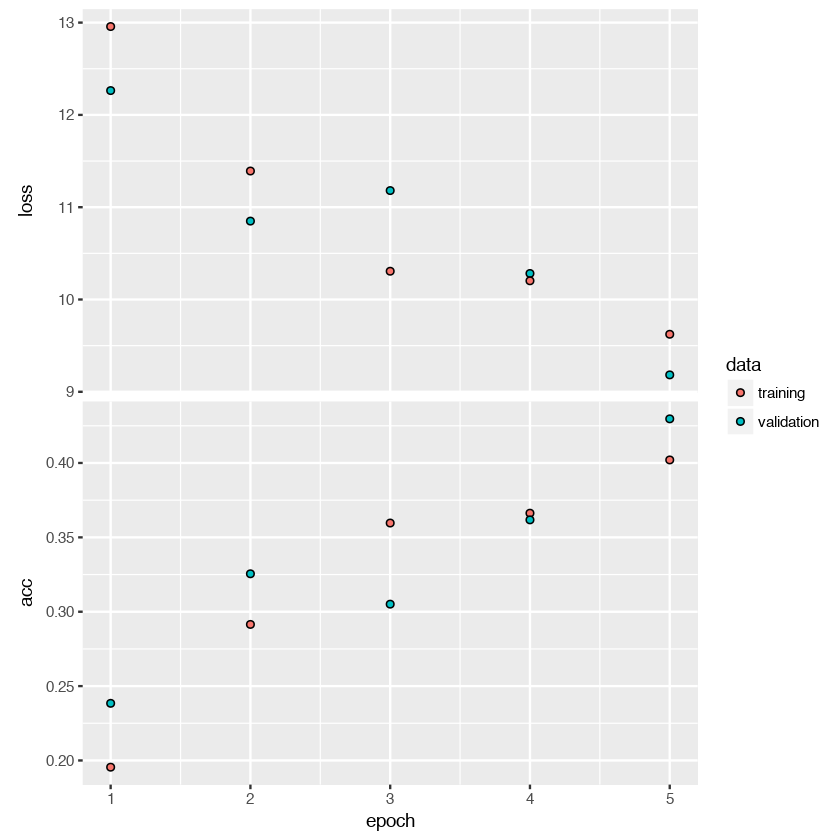

In [19]:
plot(history)

### Making predictions

In [20]:
# get the test performance of the trained model
test_perf = model %>% evaluate(x_test, y_test)
test_perf

$loss
[1] 9.189362

$acc
[1] 0.4294

In [21]:
# make hard predictions on all our test data
preds = model %>% predict_classes(x_test)
pred_frame = as.data.frame(cbind(preds, label_dict[match(preds, label_dict[, 2]), 1], y_test_noncateg))
pred_frame[, 1] = factor(pred_frame[, 1], levels = as.character(c(0:9)))
colnames(pred_frame) = c('yhat', 'yhat_label', 'y', 'y_label')
head(pred_frame)

yhat,yhat_label,y,y_label
7,sneaker,9,ankleboot
6,shirt,2,pullover
3,dress,1,trouser
3,dress,1,trouser
6,shirt,6,shirt
3,dress,1,trouser


In [22]:
# make soft predictions (softmax) on all our test data
preds = model %>% predict_proba(x_test)
soft_pred_frame = cbind(preds, y_test_noncateg)
colnames(soft_pred_frame) = c(paste0('yhat_class_', c(0:9)), 'y', 'y_label')
head(soft_pred_frame)

yhat_class_0,yhat_class_1,yhat_class_2,yhat_class_3,yhat_class_4,yhat_class_5,yhat_class_6,yhat_class_7,yhat_class_8,yhat_class_9,y,y_label
0,0,0,0,0,0,0,1,0,0,9,ankleboot
0,0,0,0,0,0,1,0,0,0,2,pullover
0,0,0,1,0,0,0,0,0,0,1,trouser
0,0,0,1,0,0,0,0,0,0,1,trouser
0,0,0,0,0,0,1,0,0,0,6,shirt
0,0,0,1,0,0,0,0,0,0,1,trouser


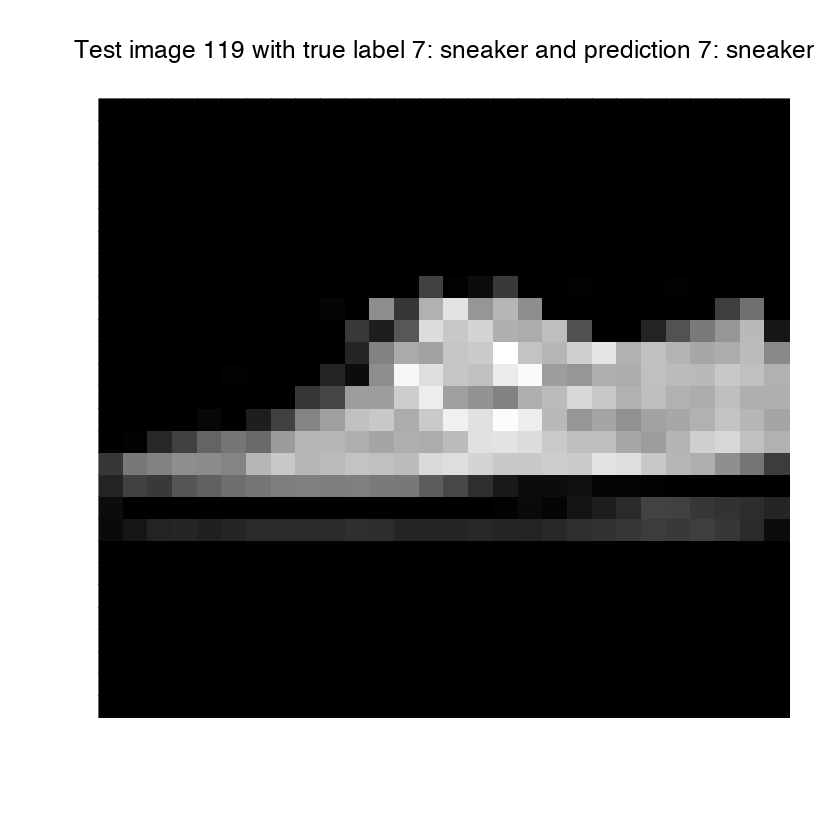

In [23]:
# check predictions for one test image
idx = 119
img_test = array_reshape(x_test[idx, ], c(28, 28))
rot = function(x){t(apply(x, 2, rev))}
# plot the image with the label as header
image(rot(img_test), 
    axes = FALSE, 
    col = grey(seq(0, 1, length = 256)), 
    main = paste0('Test image ', idx,  
                ' with true label ', 
                y_test_noncateg[idx, 1], 
                ': ', 
                y_test_noncateg[idx, 2], 
                ' and prediction ', 
                pred_frame[idx, 1], ': ', 
                pred_frame[idx, 2]))

In [24]:
# check the confusion matrix
# install.packages('caret')
library('caret')
conf = confusionMatrix(data = pred_frame[, 1], reference = pred_frame[, 3])
conf_matrix = conf$table
colnames(conf_matrix) = label_dict[, 1]
rownames(conf_matrix) = label_dict[, 1]
conf_matrix

Warning message:
“package ‘caret’ was built under R version 3.4.4”Loading required package: lattice
Loading required package: ggplot2


           Reference
Prediction  tshirt trouser pullover dress coat sandal shirt sneaker bag
  tshirt         0       0        0     0    0      0     0       0   0
  trouser        0       0        0     0    0      0     0       0   0
  pullover       0       0        0     0    0      1     0       0   0
  dress        112     933        9   760   63     11    65       0   7
  coat           0       0        0     0    0      0     0       0   0
  sandal         0       0        0     0    0    772     0      13   1
  shirt        878      67      987   234  930      4   927       0 137
  sneaker        0       0        0     0    0    193     0     986   6
  bag           10       0        4     6    7     19     8       1 849
  ankleboot      0       0        0     0    0      0     0       0   0
           Reference
Prediction  ankleboot
  tshirt            0
  trouser           0
  pullover          2
  dress             2
  coat              0
  sandal          550
  shirt     

### Saving and re-loading the model weights

In [25]:
# save model weights and architecture to hdf5 file
save_model_hdf5(object =  model, filepath = './model1.h5')

In [26]:
# load model with a new name 
loaded_model = load_model_hdf5(filepath = './model1.h5')

# check the architecture and the test performance of the loaded model
summary(loaded_model)
loaded_model %>% evaluate(x_test, y_test)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_25 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
dense_26 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dense_27 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_28 (Dense)                    (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
________________________________________________________________________________


$loss
[1] 9.189362

$acc
[1] 0.4294

## Defining the architecture - Functional

Again, we want to use a Multi-Layer-Preceptron (MLP), which consists of three inner hidden layers with varying size (128, 64, 32). For this chapter, the functional style is used. 

In [27]:
# define the start point of the architecture (input layer)
input = layer_input(shape = c(784))

# define the end point of the computational graph (predictions)
output = input %>% 
    layer_dense(units = 128, activation = 'relu', input_shape = c(784)) %>% 
    layer_dense(units = 64, activation = 'relu') %>%
    layer_dense(units = 32, activation = 'relu') %>%
    layer_dense(units = 10, activation = 'softmax')

# merge both layers to compile the model
model_func = keras_model(inputs = input, outputs = output)
model_func %>% compile(
  optimizer = 'rmsprop',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

# fit the model
history = model_func %>% fit(
    x = x_train, y = y_train, 
    epochs = 3, batch_size = 32, 
    validation_split = 0.2, 
    verbose = 1
)

# check test performance
model_func %>% evaluate(x_test, y_test)

$loss
[1] 12.97665

$acc
[1] 0.1948

In [28]:
# compare both architectures
summary(model_func)
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_7 (InputLayer)                (None, 784)                     0           
________________________________________________________________________________
dense_29 (Dense)                    (None, 128)                     100480      
________________________________________________________________________________
dense_30 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dense_31 (Dense)                    (None, 32)                      2080        
________________________________________________________________________________
dense_32 (Dense)                    (None, 10)                      330         
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_____________________________________

# 3. Different architectures: from FCN to CNN

# 4. The importance of regularization 

# 5. Using RGB images

# 6. Transfer Learning: working with pre-trained models

## (Re) sources

* [CRAN vignette for keras](https://cran.r-project.org/web/packages/keras/vignettes/getting_started.html)
* [Image manipulation in R with magick](https://cran.r-project.org/web/packages/magick/vignettes/intro.html)